<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Preprocess-10X" data-toc-modified-id="Preprocess-10X-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess 10X</a></span></li><li><span><a href="#Load-10X" data-toc-modified-id="Load-10X-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load 10X</a></span></li><li><span><a href="#Single-Cell-Aggregate" data-toc-modified-id="Single-Cell-Aggregate-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Single Cell Aggregate</a></span></li></ul></li><li><span><a href="#Main" data-toc-modified-id="Main-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Main</a></span><ul class="toc-item"><li><span><a href="#Obtain-UMAP-data" data-toc-modified-id="Obtain-UMAP-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Obtain UMAP data</a></span></li><li><span><a href="#Calculate-kmeans-clusters" data-toc-modified-id="Calculate-kmeans-clusters-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Calculate kmeans clusters</a></span></li><li><span><a href="#Plot-clusters" data-toc-modified-id="Plot-clusters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Plot clusters</a></span></li><li><span><a href="#Pseudotime" data-toc-modified-id="Pseudotime-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Pseudotime</a></span><ul class="toc-item"><li><span><a href="#Import-Scandy-elements" data-toc-modified-id="Import-Scandy-elements-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Import Scandy elements</a></span></li></ul></li></ul></li></ul></div>

# Import

In [23]:
# !pip install phate scprep umap-learn tasklogger magic-impute louvain seaborn scanpy
# !pip install git+https://github.com/jacoblevine/phenograph.git
# !pip install jupyter_contrib_nbextensions

You should consider upgrading via the 'c:\users\stéphane\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
%matplotlib inline

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
import umap

import graphtools as gt
import magic
import phenograph
import louvain

from sklearn.decomposition import PCA

# Functions

## Preprocess 10X

In [3]:
def preprocess_10X(data, name='10X-project', percent_mt=20, max_features=5000, min_features=200):
    """This function takes a data-frame (genes x cells), 
    creates a Scprep object with it and filters the object for default tags such as  
    Min and max nFeature_RNA and % of MT

    Parameters:
    @param data data-frame
    @param percent_mt integer [0-100]
    @param max_features integer [0-Inf]
    @param min_features integer [0-Inf]
    
    Returns:
    @return Preprocessed Dataframe
    """
    #Remove empty cells and empty genes
    data = scprep.filter.filter_empty_cells(data)
    data = scprep.filter.filter_empty_genes(data)
    
    #Remove elements based on mythocondrial percentage
    mt_genes = scprep.select.get_gene_set(data, starts_with=["MT-", "mt-"])
    data = scprep.filter.filter_gene_set_expression(data=data, genes=mt_genes, percentile=100-percent_mt, keep_cells='below')
    
    #Remove elements based on number of cell and number of features
    data = scprep.filter.filter_library_size(data=data, cutoff=(min_features, max_features), keep_cells='between')
    data = scprep.filter.filter_rare_genes(data=data, cutoff=0, min_cells=3)

    return data

## Load 10X

In [4]:
def load_10X(dir_path, name='10X-project',percent_mt=20, max_features=5000, min_features=200):
    """This function takes the path to a 10X output folder and instanciates the Scprep object
    
    Parameters:
    @param file string (path to file)
    @param percent_mt integer [0-100]
    @param max_features integer [0-Inf]
    @param min_features integer [0-Inf]
    
    Returns:
    @return Preprocessed DataFrame
    """
    data = scprep.io.load_10X(dir_path, sparse=True, gene_labels='both')
    return preprocess_10X(data=data, percent_mt=percent_mt, max_features=max_features, min_features=min_features)

## Single Cell Aggregate

In [21]:
def sc_aggregate(metadata, cluster_param, target_param, order_by, value_weight=0.5, pop_weight=0.5):
    """ Aggregate clusters of celltypes and extract proportion of a group
     
     
    @param metadata Target metadata dataframe
    @param cluster_param Str parameter identifying clusters
    @param target_param Str Name of the metadata feature to aggregate
    @param order_by List name of the metadata feature to order by
    @return DataFrame with different_columns of percentages
    @return Plot of percentages
    """
    keys = metadata[target_param].value_counts().keys()
    #Get percentage of population per param in metadata
    pop_perc = metadata[target_param].value_counts()/metadata[target_param].value_counts().sum() *100

    perc_keys = [x+'_perc' for x in keys]
    df=pd.DataFrame(columns=perc_keys)
    
#     df['tot_value'] = 0

    for c in sorted(metadata[cluster_param].unique()):
        #Get subset cluster data
        subset = metadata[metadata[cluster_param]==c]
        
        #Get total values 
        subset_val=subset[target_param].value_counts().to_dict()

        tot_value = subset[target_param].value_counts().sum()

        [subset_val.setdefault(k, 0) for k in keys]
        return_values = [subset_val[p]/tot_value*100 for p in subset_val]
        
        #Apply population percentage with appropriate weight
        return_values = np.array(return_values)*value_weight + np.array(pop_perc) * pop_weight 

        df.loc[c] = [round(r,2) for r in return_values]
      
    if isinstance(order_by, list):
        df = df.sort_values(by=[o+'_perc' for o in order_by], ascending=False)
    else:
        df = df.sort_values(by=order_by+'_perc', ascending=False)
        
    axis = df[[x+'_perc' for x in keys]].plot(kind="bar", stacked=True)
#     fig = axis.get_fig ure()
    
    return df, axis

# Main

In [6]:
data = scprep.io.load_csv("../data/moein_data/moein.data.csv", cell_axis = "column")
metadata = scprep.io.load_csv("../data/moein_data/moein.meta_data.csv")

c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\scprep\sanitize.py:53: RuntimeWarning: Data is not numeric. Many scprep functions will not work.
  RuntimeWarning,


In [7]:
data_phate = phate.PHATE().fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 13592 observations and 3897 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 7.00 seconds.
    Calculating KNN search...
    Calculated KNN search in 49.20 seconds.
    Calculating affinities...
    Calculated affinities in 28.46 seconds.
  Calculated graph and diffusion operator in 84.98 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.82 seconds.
    Calculating KMeans...
    Calculated KMeans in 25.50 seconds.
  Calculated landmark operator in 32.29 seconds.
  Calculating optimal t...
    Automatically selected t = 6
  Calculated optimal t in 5.80 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.72 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.58 seconds.
Calculated PHATE in 131.38 seconds.


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

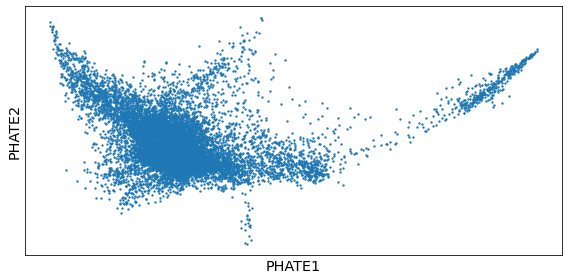

In [8]:
scprep.plot.scatter2d(data_phate, figsize=(8,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

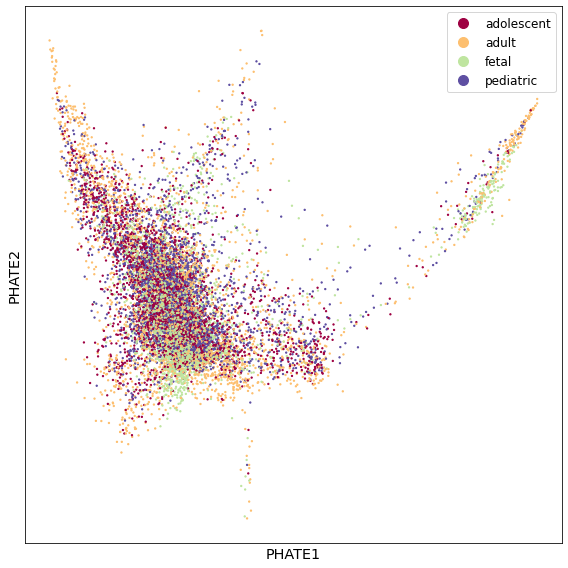

In [9]:
scprep.plot.scatter2d(data_phate, c=metadata["age"],figsize=(8,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

## Obtain UMAP data

In [10]:
#Obtain UMAP data
with tasklogger.log_task("UMAP"):
    data_umap = umap.UMAP(n_components=60).fit_transform(data)
    data_umap = pd.DataFrame(data_umap, index=data.index)

Calculating UMAP...
Calculated UMAP in 57.18 seconds.


## Calculate kmeans clusters

In [11]:
kmeans_clusters = sklearn.cluster.KMeans().fit_predict(data_umap)

## Plot clusters

<AxesSubplot:title={'center':'Clusters according to umap'}, xlabel='0', ylabel='1'>

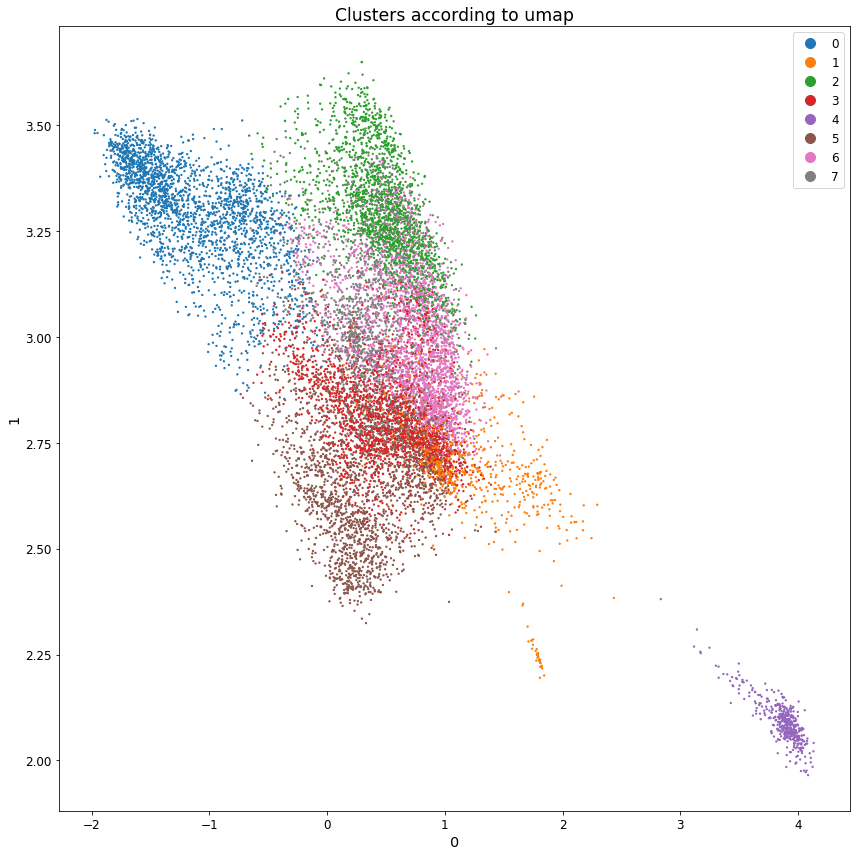

In [12]:
# scprep.plot.scatter2d(data_umap, c=metadata['age'],figsize=(12, 12),  title="Clusters according to umap")
scprep.plot.scatter2d(data_umap, c=kmeans_clusters,figsize=(12, 12),  title="Clusters according to umap")

In [13]:
metadata

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.6,seurat_clusters,age,S.Score,G2M.Score,Phase,integrated_snn_res.0.4
TCGCGAGGTTTAGGAA_1,HP773,1034.000000,650,3.288201,3.0,5,pediatric,-0.023260,-0.018602,G1,5
ACCTTTATCGTGACAT_1,HP773,2673.000000,1391,3.179948,4.0,0,pediatric,-0.051620,0.117481,G2M,0
CGGAGCTTCCGCATCT_1,HP773,927.000000,610,1.402373,3.0,0,pediatric,-0.037142,-0.079287,G1,0
CGCTGGAGTCGTTGTA_1,HP773,1820.000000,1034,3.241758,3.0,0,pediatric,0.005744,0.011691,G2M,0
GTGTGCGAGCGGCTTC_1,HP773,617.000000,365,3.727715,2.0,6,pediatric,-0.009725,-0.019488,G1,6
...,...,...,...,...,...,...,...,...,...,...,...
CTGCCTACAAGCTGAG_12,HF588,804.302460,337,1.001472,0.0,2,fetal,0.105172,-0.052438,S,2
TCGCGAGGTTGCTCCT_12,HF588,772.912931,310,1.519034,0.0,2,fetal,-0.004290,-0.050681,G1,2
AGAGCTTTCACCCGAG_12,HF588,930.952502,446,1.893067,2.0,0,fetal,-0.032441,-0.032703,G1,0
CTCGAAAAGATCGGGT_12,HF588,882.212233,393,2.471061,1.0,2,fetal,-0.018380,0.063663,G2M,2


,pediatric_perc,adolescent_perc,fetal_perc,adult_perc
1,31.42,26.96,25.44,16.18
3,29.61,27.79,24.80,17.80
5,28.71,26.98,24.44,19.86
0,28.86,27.74,22.76,20.64
4,34.61,27.14,22.25,16.00
6,34.27,29.78,20.55,15.39
8,38.21,23.01,19.46,19.31
2,57.95,15.15,13.66,13.25


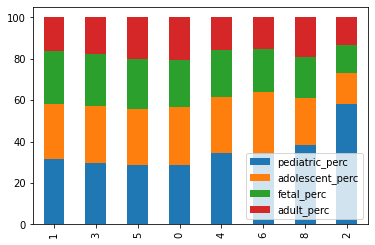

In [22]:
df, axis = sc_aggregate(metadata=metadata, 
                        cluster_param ='seurat_clusters', 
                        target_param = 'age', 
                        order_by = ['fetal'])

df

## Pseudotime

In [25]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 7.2.0
anndata             0.7.4
backcall            0.2.0
cffi                1.14.2
colorama            0.4.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
deprecated          1.2.10
future              0.18.2
get_version         2.1
graphtools          1.5.2
h5py                2.10.0
igraph              0.8.2
importlib_metadata  1.7.0
ipykernel           5.3.4
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.17.2
joblib              0.16.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
llvmlite            0.34.0
louvain             0.7.0
magic               2.0.3
matplotlib          3.3.1
mpl_toolkits        NA
natsort             7.0.1
nt                  NA
ntsecuritycon       NA
numba               0.51.0
numexpr             2.7.1
numpy               1.19.1
packaging           20.4
pandas              1.1.1
parso

In [58]:
# adata = sc.read("../data/olivier_trial_data/14_EAE_all_cells.MPS12344479-A02.sorted.1229.merged.10x_outputs/filtered_feature_bc_matrix/matrix.mtx.gz")
# # adata = sc.datasets.paul15()
# adata.obs
adata = sc.AnnData(data)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: []."

In [57]:
adata = sc.datasets.paul15()
adata.obs

c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\anndata\_core\anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'paul15_clusters' as categorical
c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.


,paul15_clusters
0,7MEP
1,15Mo
2,3Ery
3,15Mo
4,3Ery
...,...
2725,2Ery
2726,13Baso
2727,7MEP
2728,15Mo


In [35]:
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
    finished (0:00:00)


c:\users\stéphane\appdata\local\programs\python\python37\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [36]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [37]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:11)


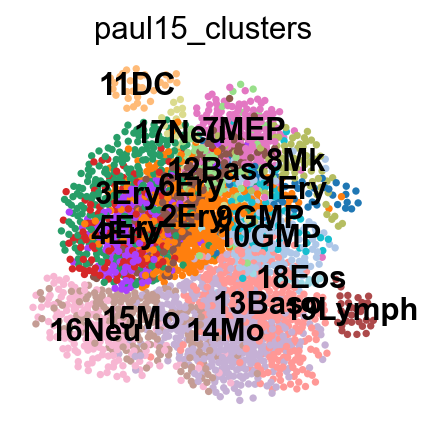

In [38]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')


,paul15_clusters,n_counts_all
0,7MEP,353.0
1,15Mo,2556.0
2,3Ery,4649.0
3,15Mo,4486.0
4,3Ery,5205.0
...,...,...
2725,2Ery,4873.0
2726,13Baso,3553.0
2727,7MEP,443.0
2728,15Mo,3252.0
